In [1]:
!pip install IPython  
from IPython.display import Image

In [ ]:
import os, re

def preprocess_sentence(sentence):
sentence = sentence.lower().strip() # 1. 소문자로, 공백 없애기
sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2. 특수문자 양쪽에 공백
sentence = sentence.strip() # 5. 양쪽 공백 지우기. 1번에서도 공백 없애기 했는데 두번째이네
sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러개 공백은 공백 하나로

return sentence

# (1) 데이터 전처리

# 1. 필요한 라이브러리 불러오기

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

# 2. 데이터 판다스로 불러오기

In [3]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
25766,I dropped my keys.,J'ai fait tomber mes clés.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
208626,I just want to say how thankful I am for all y...,Je veux simplement exprimer combien je suis re...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
126316,What should I do if Tom calls?,Que devrais-je faire si Tom appelle ?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
18087,Where's the cat?,Où est le chat ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
148514,Could you tell me your name again?,"Pourriez-vous, de nouveau, me dire votre nom ?",CC-BY 2.0 (France) Attribution: tatoeba.org #2...


# 2-1. 불필요한 열 삭제하고, 훈련데이터 5만개로 줄이기

In [4]:
lines = lines[['eng', 'fra']][:50000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
31269,Don't tell anybody.,Ne le dis à quiconque !
15500,I won the fight.,J'ai gagné le combat.
42501,Those were the days.,C'était le bon temps.
7079,Do you get it?,Pigez-vous ?
14147,Did someone die?,Quelqu'un est-il mort ?


# 3. 디코더에 시작 토큰 \t (<sos>), 종료 토큰 \n (<eos>) 추가하기

In [5]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 50000


,eng,fra
2571,Tom stayed.,\t Tom est resté. \n
31452,Get out of my seat.,\t Sors de mon siège ! \n
25284,He speaks English.,\t Il parle anglais. \n
13318,We're freezing.,\t On se gèle. \n
21895,"Spit it out, Tom.","\t Crache-la, Tom. \n"


# 4. Tokenizer(단어 사전, 단어장) 생성하기
이제 단어장(vocabulary)을 만들고, 
각 단어에 부여된 고유한 정수로, 텍스트 시퀀스를 정수 시퀀스로 변환하는 정수 인코딩 과정을 거친다

이때 영어와 프랑스어는 사용하는 언어가 다르므로 단어장을 별도로 만들어줍니다. 
그리고 정상적으로 정수 시퀀스로 변환되었는지 3개의 행을 출력합니다.

In [6]:
eng_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행 # fit_on_texts 메서드 찾아보기
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장 # 이미 texts_to_sequences가 되어있나?
input_text[:3]

[[19, 4, 7], [19, 4, 7], [19, 4, 7]]

In [7]:
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[10, 1, 19, 5, 1, 31, 1, 11],
 [10, 1, 15, 5, 12, 16, 29, 2, 14, 1, 11],
 [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]

# 5. 단어장의 크기를 변수에 담아주기(0번 토큰도 있으므로 +1하기)

In [8]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73


In [9]:
# 프랑스어 토크나이저된(알파벳 기준으로 나눔) 단어장, word:index의 구조로 되어있음
fra_tokenizer.word_index

{' ': 1,
 'e': 2,
 's': 3,
 't': 4,
 'a': 5,
 'i': 6,
 'n': 7,
 'u': 8,
 'o': 9,
 '\t': 10,
 '\n': 11,
 'r': 12,
 'l': 13,
 '.': 14,
 'm': 15,
 'c': 16,
 'p': 17,
 'd': 18,
 'v': 19,
 "'": 20,
 'é': 21,
 'j': 22,
 'f': 23,
 '-': 24,
 'b': 25,
 '?': 26,
 'q': 27,
 'g': 28,
 'h': 29,
 'z': 30,
 '!': 31,
 'x': 32,
 'ê': 33,
 'à': 34,
 'y': 35,
 'è': 36,
 'ç': 37,
 '\u202f': 38,
 '\xa0': 39,
 ',': 40,
 'î': 41,
 'ô': 42,
 '’': 43,
 'ù': 44,
 'û': 45,
 'â': 46,
 'œ': 47,
 'k': 48,
 'ï': 49,
 '0': 50,
 'w': 51,
 '1': 52,
 '3': 53,
 '\u2009': 54,
 '2': 55,
 '9': 56,
 'ë': 57,
 '«': 58,
 '»': 59,
 '5': 60,
 '7': 61,
 '8': 62,
 ':': 63,
 '6': 64,
 '4': 65,
 '%': 66,
 '"': 67,
 '&': 68,
 '(': 69,
 ')': 70,
 '$': 71,
 '‘': 72}

In [10]:
eng_tokenizer.word_index

{' ': 1,
 'e': 2,
 't': 3,
 'o': 4,
 'i': 5,
 'a': 6,
 '.': 7,
 's': 8,
 'r': 9,
 'n': 10,
 'h': 11,
 'l': 12,
 'd': 13,
 'y': 14,
 'u': 15,
 'm': 16,
 'w': 17,
 "'": 18,
 'g': 19,
 'c': 20,
 'p': 21,
 'k': 22,
 'b': 23,
 'f': 24,
 'v': 25,
 '?': 26,
 'j': 27,
 '!': 28,
 'x': 29,
 ',': 30,
 'z': 31,
 'q': 32,
 '0': 33,
 '-': 34,
 '3': 35,
 '1': 36,
 '2': 37,
 '9': 38,
 ':': 39,
 '5': 40,
 '7': 41,
 '8': 42,
 '6': 43,
 '$': 44,
 '"': 45,
 '%': 46,
 '4': 47,
 'é': 48,
 '’': 49,
 '&': 50,
 '/': 51}

# 6. 영어 데이터, 프랑스어 데이터들의 최대 길이 구하기
# 또 기본 통계 정보도 구하기(패딩하기 위해)

In [11]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 21
프랑스어 시퀀스의 최대 길이 69


In [12]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73
영어 시퀀스의 최대 길이 21
프랑스어 시퀀스의 최대 길이 69


# 7. 프랑스어 데이터, 즉 프랑스어 시퀀스를 2가지 버전(입력 데이터, 출력 데이터)으로 준비

인코더의 입력으로 사용되는 영어 시퀀스와 달리, 프랑스어 시퀀스는 2가지 버전으로 나누어 준비

1. 디코더의 출력과 비교해야 할 정답 데이터로 사용하기 위해
2. 교사 강요(Teacher forcing)을 위해 디코더의 입력으로 사용하기 위해


같은 문장을 굳이 2가지 버전으로 나누는 이유는, 
디코더의 입력으로 사용할 시퀀스는 <eos> 토큰이 필요가 없고, 디코더의 출력과 비교할 시퀀스는 <sos>가 필요가 없기 때문
    
가령, 영어로 'I am a person'이라는 문장을 프랑스어 'Je suis une personne'로 번역하는 번역기를 만든다고 해봅시다. 
훈련 과정에서 디코더는 '<sos> Je suis une personne'를 입력받아서 'Je suis une personne <eos>'를 예측하도록 훈련되므로, 
이런 방식으로 생성된 두가지 버전의 시퀀스를 준비

In [13]:
fra_tokenizer.word_index[eos_token]
# 이건 왜 출력해본걸까.. 아 숫자 11은 <eos> 토큰을 의미하는 걸 확인하기 위해서 였던 것 같다
# 숫자 10은 <sos> 시작을 의미하는 토큰

11

In [15]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]


# 리스트 내포 실행순서 공부하기

In [16]:
print(decoder_input[:3])
print(decoder_target[:3])

[[10, 1, 19, 5, 1, 31, 1], [10, 1, 15, 5, 12, 16, 29, 2, 14, 1], [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1]]
[[1, 19, 5, 1, 31, 1, 11], [1, 15, 5, 12, 16, 29, 2, 14, 1, 11], [1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]


# 8. 영어 데이터, 프랑스어 입력 데이터, 프랑스어 출력 데이터 각각에 패딩
max_eng_seq_len, max_fra_seq_len 활용

In [17]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post') # 뒤에 패딩
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21)
프랑스어 입력데이터의 크기(shape) : (50000, 69)
프랑스어 출력데이터의 크기(shape) : (50000, 69)


In [18]:
print(encoder_input[0])

[19  4  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [19]:
decoder_input[0].shape

(69,)

# 9. 원핫 인코딩 진행
이제 각 정수에 대해서 벡터화 방법으로 원-핫 인코딩을 진행

In [20]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21, 52)
프랑스어 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 69, 73)


원-핫 인코딩을 하고나서의 데이터의 크기는 (샘플의 수 × 샘플의 길이 × 단어장의 크기) 가 됩니다. 
원-핫 인코딩은 각 정수를 단어장의 크기를 가지는 원-핫 벡터로 인코딩하는 과정이기 때문입니다.

# 10. 훈련용 데이터, 검증용 데이터 나누어주기
훈련과정의 validation을 위해 위에서 생성한 데이터 50000건 중 3000건만 검증데이터로 삼고, 
나머지를 학습데이터로 삼겠습니다.

In [18]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (50000, 21, 52)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 69, 73)


# (2) 모델 훈련하기
# 0. 필요한 도구 임포트

In [21]:

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

print('⏳')

⏳


# 1. 인코더 설계

In [23]:
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None, eng_vocab_size)) # 한 배치사이즈의 크기 (None, eng_vocab_size) 이 부분 숫자 맞는지, none이라 한 이유는? 
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = 256, return_state = True) # return_state = True로 해서 hidden state와 cell state를 리턴받을 수 있도록 합니다
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

### 여기에서는 함수형 API로 모델을 쌓은 건가요? 네!

### 인코더에 넣을 때는 텐서의 형태로 넣어주어야 한다? 네..!

### 순환층을 셀이라고 하고, 하나의 셀은 여러개의 뉴런으로 구성된다고 하는데, 위에서 256개라고 하면 하나의 LSTM 
### 층 안에 256개의 작은 셀들이 있는 거라고 생각하면 될까요? 네!

### hidden_size가 256이면 hidden_state로 나오는 값이 256개가 된다는 의미일까요? 네!

### return_sequence 와 return_state가 있는데
return_seauence=true는 모든 타임 스텝의 hidden state를 출력
예: 길이가 6이면 총 6개의 hidden state값이 나옴

return_state=true는 마지막 타임 스텝의 output(hidden state) 
### <- 결국에는 output이 곧 hidden state인가요?? 네!
무튼 output, hidden state, cell state가 출력된다(아아 이게 최종이었네)
즉 마지막 output 값이 2번 출력되고 cell state가 나온다


### 위 코드에서의 encoder_outputs와 state_h는 같은 값인가요??? 네!







### 질문! encoder_outputs나 state_h는 tensor로 나오던데 어떻게 확인하면 되나요?
아래와 같이 텐서로 출력되는 것으로 확인하나요?

### encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) 여기에서 출력값은
원래 lstm 레이어에서는 세개로 나누어 나오나요? ㅇ아아 모델의 그림을 보면 ht, ht, ct 이렇게 나오므로~
내가 변수만 다르게 넣은 것 같다



In [24]:
encoder_lstm(encoder_inputs)

[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>]

In [25]:
encoder_outputs

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>

In [26]:
state_h

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>

In [27]:
state_c

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>

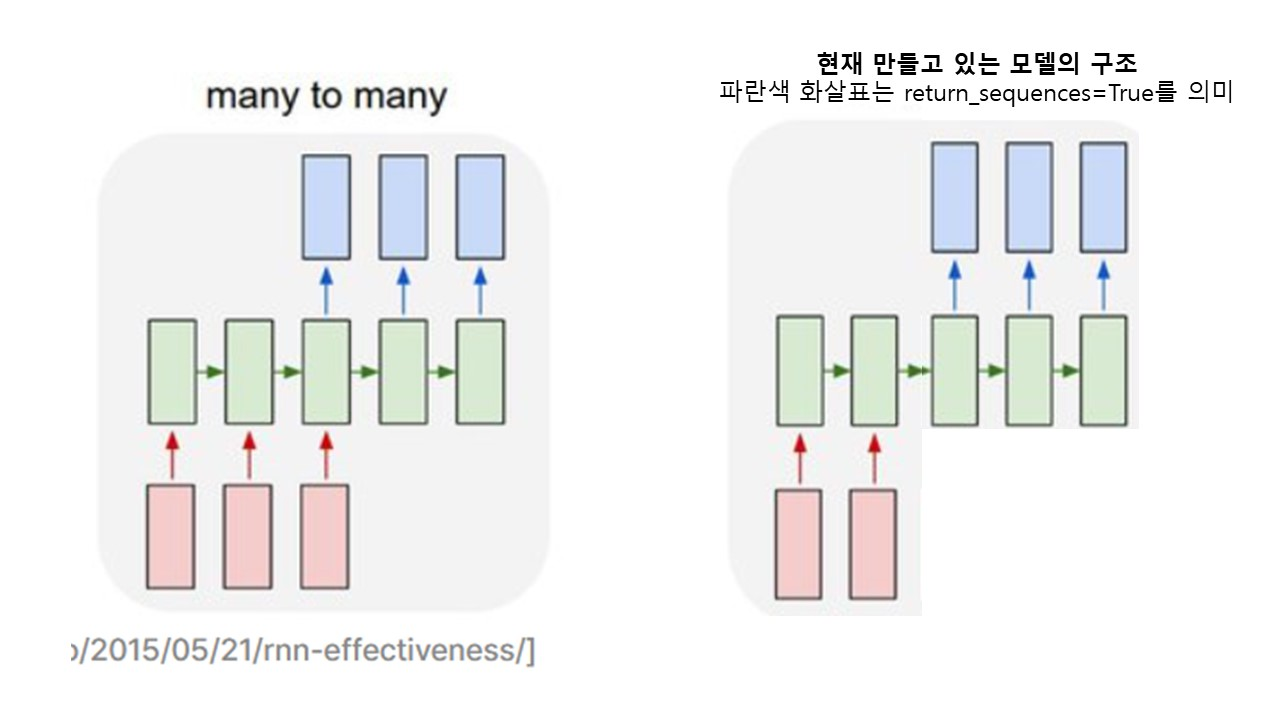

In [29]:
Image("[GD_7_Translator] images/01.jpg")

# 2. 디코더 설계

In [ ]:
# 코드 돌리진 말기
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size)) # fra_vocab_size = len(fra_tokenizer.word_index) + 1 이렇게 해서 나온 것
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True) # 여기에서는 return_sequence=True를 주었다, 매 hidden state를 출력하기 위해?
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)

### 이렇게 되면, 
return_seauences=true이니 
디코더 lstm에서 매 타임스텝의 hidden state를 출력하고

return_state=true이니
디코더 lstm에서 나오는 최종 hidden state와 cell state를 출력한다????


### 질문! decoder_outputs은 return_sequences=true를 통해 나오는 매 타임스텝마다의 hidden_state가 다 담긴 변수?
### returen_sequences를 설정하든 안하든 decoder_outputs, encoder_outputs은 나오는거죠?
### encoder_outputs에서 담긴 건 최종 타임스텝의 hidden_state? 아니면 cell state도 같이? - hidden_state만 인듯!

In [ ]:
인코더는 이렇게 했는데, 
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) 여기에서

decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states) 
이렇게 decoder_lstm()안에 변수를 두 개 넣을 수 있나봐 신기

In [ ]:
기본적으로 LSTM은 3차원 텐서이지요 (배츠사이즈, 타임, 피쳐) 라고 한느데
https://www.facebook.com/groups/TensorFlowKR/permalink/954273444913714/

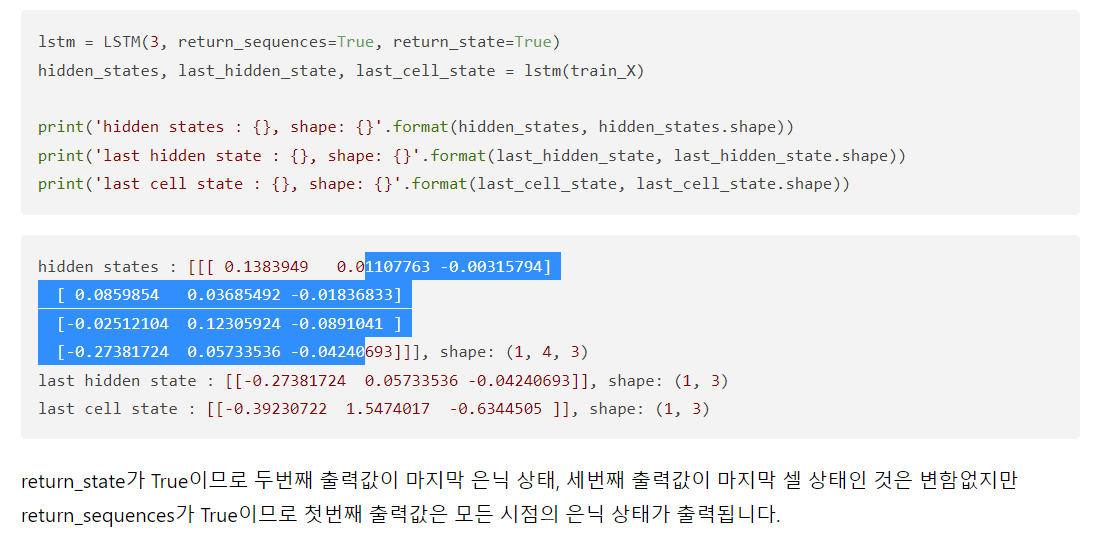

In [28]:
Image("[GD_7_Translator] images/05.PNG")

# 질문! 여기에서 출력값의 hidden states가 왜 4개의 값이 나오지? units의 수를 3개 있으면 3개 아닌가?


챗gpt에게 물어보니 4번의 타임스텝이 있다고 한다
처음에 입력을 만들 때 단어 벡터의 차원은 5이고, 문장의 길이가 4인 경우를 가정한 입력을 만들었었다.

train_X = [[0.1, 4.2, 1.5, 1.1, 2.8], [1.0, 3.1, 2.5, 0.7, 1.1], [0.3, 2.1, 1.5, 2.1, 0.1], [2.2, 1.4, 0.5, 0.9, 1.1]]
print(np.shape(train_X))

# 또 다른 질문
# 단어 하나당 벡터의 차원은 5, 문장의 길이는 4로 만들었는데
lstm을 지나면 decoder_outputs에는 [00000 000000 000000] 이렇게 한 문장당 세 개의 값이 나온다.
### 한 문장에 대한   5차원의 벡터값이 3차원으로 바뀐거라고 이해하면 되나? 
### lstm안에서 설정한 units의 수가 3이었기 때문에?
### 항상 이 유닛수는 한 문장의 00차원의 수보다 작아야 하나요? 커도 괜찮나요?

In [ ]:
다시 디코더 만드는 코드를 보면

In [ ]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size)) # fra_vocab_size = len(fra_tokenizer.word_index) + 1 이렇게 해서 나온 것
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)



### 이렇게 되면, 
return_seauences=true이니 
디코더 lstm에서 매 타임스텝의 hidden state를 출력하고,

return_state=true이니
디코더 lstm에서 나오는 최종 hidden state와 cell state를 출력한다???? 응 그런 것 같아

decoder_outputs는 모든 time step의 hidden state?? - 어디서 나온 말이야? 무슨 뜻?
아 그러게 return_sequences니까 모든 타임 스텝의 히든 스테이츠가 decoder_outputs에 담기는 걸까? 오호오호

decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)

1. 이렇게 decoder_lstm 층 안에(decoder_inputs를 넣고, 매개변수인 initial_state를 넣으면 
이 때의 initial_state는 encorder_states로 
encorder_states가 뭐였냐 하면 encoder_states = [state_h, state_c] 이렇게 나온 값

그래서 encorder에서 나온 마지막 타임스텝의 hidden_state와 cell state를 디코더 lstm의 초기 상태를 정의해 줌
initial_state가 추가되었는데요. LSTM 셀의 초기 상태를 정의해줄 수 있는 인자



2. 여기 코드에서 _,_를 한 이유는 첫번째 _에는 state_h, state_c가 나오는데 _의 의미는 이 부분을 불러오지 않겠다는 의미이겠지
왜? 여기에서는 출력 문장을 재생성하는 층이므로 마지막에 나오는 decorder_outputs만 중요하지, state_h, state_c는 굳이 필요 없으므로


또 state_h, state_c는 return_state=true를 통해서 나온 값이다. 마지막 타임스텝의 hidden state, cell state

그런데 이 디코더에서는 필요가 없다고 한다. 음 이유는 뭘까?
### 전체 타임스텝의 hidden_state를 통해서 각 히든 스테이트마다 단어들을 번역하려고?
### 각 히든 스텝들이 한 단어들이 되는건가?????
### 히든 스테이트에서 나오는 값이 정확히 무엇을 의미하는가? 

위에서 출력문장을 재생성하는 층이므로 decoder_outputs만 중요하다....?고 썼다.
참고로 인코더에서는
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]
게 했다.


### 잠깐! 교사강요가 어디에서 적용되는건가?

-> 이게 훈련과정인거니까, 교사 강요를 적용한 걸까?

아까 교사강요를 적용한거는 어떻게 한다고 했지?


위에서 교사강요를 위해 이 디코더 시퀀스는 디코더의 입력으로 사용하기 위한 것이라고 했어. 
이 시퀀스는 문장의 끝을 알려주는 <EOS> 토큰이 필요없다고 했어
    

## 아 그래서 <EOS> 토큰을 뺀 decoder_input에 담긴 시퀀스 데이터들을 사용하는거!    
    전처리단계에서 2가지 버전을 만들때 decoder_input과 decoder_target을 만들었는데, 교사강요에서는 decorder_input을 사용
    실습에서 먼저 설계한 디코더는 decorder_input인 것 같아
    
    
아까
# 종료 토큰 제거
# decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
    
이렇게 해주었어
    
    숫자 11(<EOS> 토큰 의미)가 제거되었음

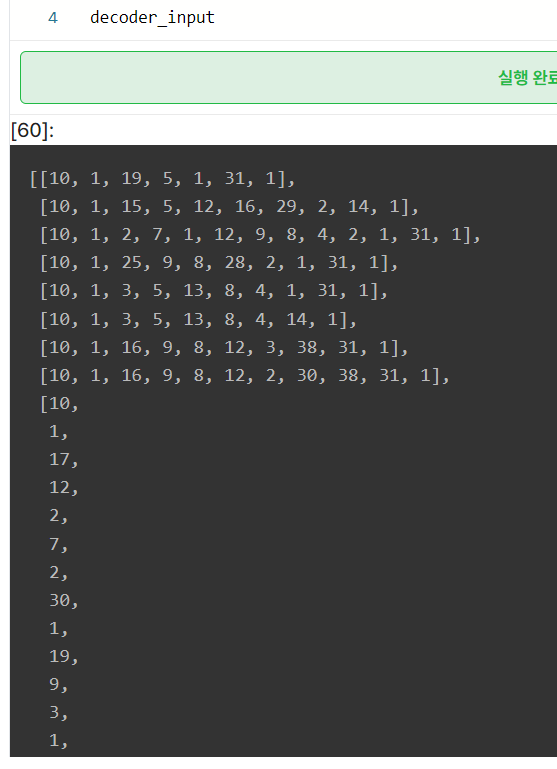

In [31]:
Image("[GD_7_Translator] images/07.PNG")

In [ ]:
이렇게 종료토큰을 제거했던 decoder_input을 그 다음에는 패딩을 해줌

decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')

그럼
프랑스어 입력데이터의 크기(shape) : (50000, 69)
    이렇게 나옴
    

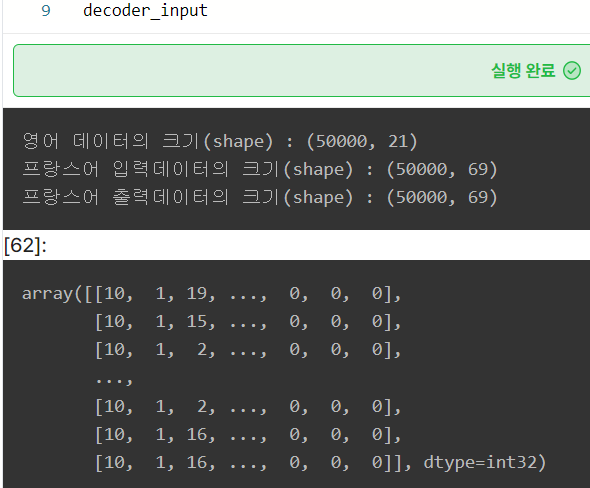

In [32]:
Image("[GD_7_Translator] images/08.PNG")

In [ ]:
패딩을 하고 나면 이렇게 보임

In [ ]:
그리고 나면 이제 원핫 인코딩


decoder_input = to_categorical(decoder_input)
프랑스어 입력데이터의 크기(shape) : (50000, 69, 73) 이렇게 됨
    
    
원핫인코딩 후 
decoder_input[:3] 해보면

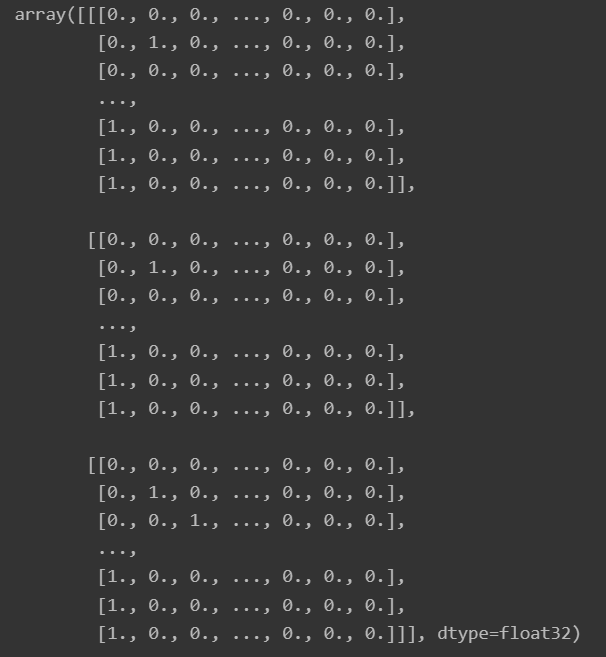

In [33]:
Image("[GD_7_Translator] images/09.PNG")

In [ ]:
3개가 나오는데 하나당 73차원이라는 거겠지?

음..


여기에서 (50000, 69, 73) 원핫인코딩후 데이터의 크기는 
(샘플의 수*샘플의 길이*단어장의 크기)라고 한다.


그럼 50000이 샘플의 수, 69가 샘플의 길이 - 패딩을 max_fra_seq_len으로 했는데 이 때의 숫자가 69였다

73이 단어장의 크기라고 하는데 이거는 fra_vocab_size의 값이 73이었다.



그렇게 되면 위 데이터는 총 3개의 샘플에 대한 원핫인코딩이 된 값이라 할 수 있는데 


In [34]:
decoder_input[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
decoder_input[0].shape

(69, 73)

In [36]:
decoder_input[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [37]:
decoder_input[0][1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [38]:
len(decoder_input[0][0])

73

In [39]:
decoder_input[0][0].shape

(73,)

아 한 줄에 들어있는게 73개이네


단어장의 크기는 73
단어장에 들어가있는 단어는 73개
그럼 단어의 개수만큼 원핫인코딩을 하니까 가로 하나가 73개의 값이 들어가는 것 같다:)
    
하나의 decoder_input에 들어있는 샘플의 수는 50000개
그 중 하나는

In [40]:
decoder_input[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
인데 가로 73개 세로 69개

이 말은 샘플 하나의 문장 길이가 69, 단어 69(max_fra_seq_len)이었으니까
하나의 단어당 73차원으로 표현한 거라고 이해하면 될까?

### 질문! 0번 토큰을 고려하여 +1을 하고 저장해줍니다. 이 부분에서 <pad>는 나중에 알아서 eng_tokenizer.word_index
fra_tokenizer.word_index에 포함되는 건가요?

In [ ]:
원핫인코딩을 해준 다음에는

n_of_val = 3000

decoder_input_train = decoder_input[:-n_of_val]
decoder_input_test = decoder_input[-n_of_val:]

In [ ]:
을 통해 훈련용, 검증용 데이터로 나누어줌

# 그래서 디코더 설계(교사강요를 위한, 종료 토큰을 뺀 decoder_input으로 만든 데이터를 활용한)를 다시 보면

In [28]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size)) # 이거는 73이었음
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)

# 디코더 출력층 설계

In [29]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax') # fra_vocab_size = 73 이었음
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [30]:
decoder_outputs

<KerasTensor: shape=(None, None, 73) dtype=float32 (created by layer 'dense')>

In [31]:
decoder_outputs[1]

<KerasTensor: shape=(None, 73) dtype=float32 (created by layer 'tf.__operators__.getitem')>

## 매 타임스텝마다의 다중 클래스 분류 문제라고 하는데.. 읭? 그게 무슨 의미?
그래서 프랑스어 단어장으로부터 한가지 문자만 선택한다
소프트맥스의 확률로 나오는 걸 
## 텐서의 값을 실제로 볼 수는 없는건가?

나오는 소프트맥스의 확률값으로 다음에 올 한 글자를 예측

# 최종적으로 인코더와 디코더를 연결함

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()
# 함수형 API

In [ ]:
함수형 API에서
model = keras.Model(inputs=inputs, outputs=outputs) 로 사용

이걸 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 에 대입해보면

[encoder_inputs, decoder_inputs] 이 부분이 잘 이해가 가지 않는 건데

음.. 왜 이해가 안돼?

In [43]:
[encoder_inputs, decoder_inputs]

[<KerasTensor: shape=(None, None, 52) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, 73) dtype=float32 (created by layer 'input_2')>]

## 질문! 이렇게 출력해보면 이렇게 나오는데, 그럼 이거는 한 리스트안에 두 개의 인풋 텐서를 담아주었다는 의미인가?

충돌이 일어나지는 않나?
그럼 인코더에서는 알아서 encoder_inputs만 들어가서 학습되는건가?


모델이 학습을 할 때 인풋에 두 가지 종류의 인풋이 들어가는 건데 
encoder_inputs이 들어갈 차례에는 encoder_inputs이 학습되고, decoder_inputs이 들어갈 차례에는 decoder_inputs이 들어가는 건가?

<인코더>
입력 텐서 생성.
encoder_inputs = Input(shape=(None, eng_vocab_size))

hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = 256, return_state = True)

디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]


<디코더>
입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size)) # 이거는 73이었음

hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)

decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states) <- 이 부분에서만 인코더랑 연결해줌


-> 그래서 여기에서 encoder_outputs은 사용하지 않을 것이기 때문에 따로 변수에 담아주지 않았을까?

# 다시 돌아와서 모델을 컴파일 하고 서머리를 출력해보면

In [44]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 52)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 316416      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 lstm[0][1]                   

# 이 connected to 부분이 잘 이해가 안돼요.

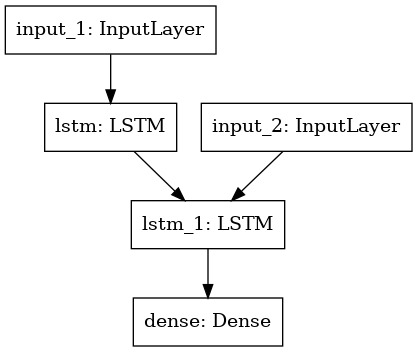

In [46]:
from tensorflow.keras import utils 
utils.plot_model(model)

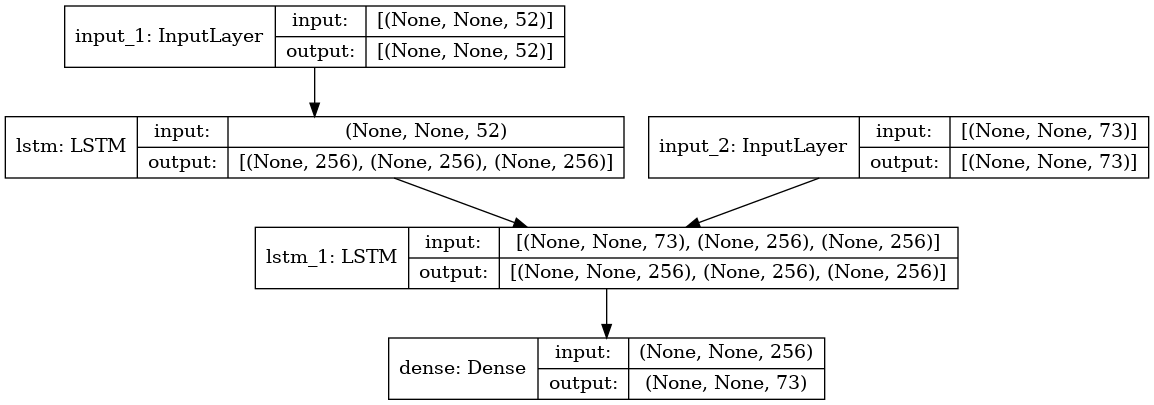

In [48]:
from tensorflow.keras import utils 
utils.plot_model(model, show_shapes=True)

In [ ]:
input_1에서 영어 단어장의 크기가 52
lstm에서 output의 256은 units=256이었음, 왜 [ , , ]? 값이 세 개가 들어있을까?
아 encoder_outputs, state_h, state_c라서?!

input_2에서 프랑스어 단어장의 크기가 73
lstm_1에서 프랑스 인풋을 넣고, 거기에 encoder 에서의 state_h와 state_c를 넣으면
output으로는 lstm_1 디코더의 lstm 층에서 역시 units=256으로 주었기에 256으로 나옴
세 개가 나오는 이유는 decoder_output, decoder에서의 마지막 hidden_state, cell_state인 것 같다

여기에서 output이 (None, None, 256) 이렇게 나오는 건 음.. 모든 타임스텝의 히든 스테이트를 출력한 것들의 모임인데
그게 3차원이 되는건가? 그래서 그런가?

그리고 보면 inputlayer에서는 다 none, none, 52 / none, none, 73이다
이유는?

밑에서 살펴보면

In [47]:
lstm[0][1]

NameError: name 'lstm' is not defined

In [49]:
decoder_inputs

<KerasTensor: shape=(None, None, 73) dtype=float32 (created by layer 'input_2')>

decoder_inputs = Input(shape=(None, fra_vocab_size)) 이렇게 정의한 거였는데

## 여기까지만 보면 2차원아닌가, 3차원이 되는 이유는?

# 다시 model.fit으로 돌아오면

In [50]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=10)

Epoch 1/10
368/368 [==============================] - 40s 21ms/step - loss: 0.9704 - val_loss: 0.8352
Epoch 2/10
368/368 [==============================] - 7s 18ms/step - loss: 0.5932 - val_loss: 0.6803
Epoch 3/10
368/368 [==============================] - 7s 19ms/step - loss: 0.4941 - val_loss: 0.5942
Epoch 4/10
368/368 [==============================] - 7s 18ms/step - loss: 0.4325 - val_loss: 0.5324
Epoch 5/10
368/368 [==============================] - 7s 18ms/step - loss: 0.3935 - val_loss: 0.4986
Epoch 6/10
368/368 [==============================] - 7s 18ms/step - loss: 0.3625 - val_loss: 0.4730
Epoch 7/10
368/368 [==============================] - 6s 18ms/step - loss: 0.3399 - val_loss: 0.4489
Epoch 8/10
368/368 [==============================] - 6s 18ms/step - loss: 0.3217 - val_loss: 0.4308
Epoch 9/10
368/368 [==============================] - 6s 18ms/step - loss: 0.3068 - val_loss: 0.4201
Epoch 10/10
368/368 [==============================] - 6s 18ms/step - loss: 0.2944 - val_l

1. 여기에서 x를 보면 x에 encoder_input_train, decoder_input_train이 들어간다

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 이 부분의 
([encoder_inputs, decoder_inputs]과 비슷해 보임

2. 인풋에는 decoder_target_train이 들어가지 않지만, y에는 decoder_target_train이 들어간다.
-> 아 이 부분 때문에 
-> y는 outputs에 해당하는 건가?

보통 model.fit(inputs, targets, epochs, batch_size)라고 하면
targets에는 훈련 타깃이고 inputs는 입력 샘플이라고 한다

그럼 여기에서 y는 decoder_target_train이 target이 되는 걸까? 훈련 타깃

그래서 디코더의 출력과 비교할 정답 데이터로 사용→ <SOS> 토큰 필요 없음 이렇게? 
decoder_target_train이게 정답데이터가 되는 것? (그런듯!!)
    
    
    
 
 

*아까 훈련용/검증용 데이터를 이렇게 나눔

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

# 5-9. 모델 테스트하기

이제 테스트를 해 볼 건데
이를 위해서 테스트 단계의 디코더 모델은 설계를 다시 해줄 필요가 있다. 


물론 이전에 학습된 디코더 모델의 레이어는 그대로 사용
왜 이렇게 번거로운 과정이 생기는 것일까? 

Text Generator 모델을 만들어 보신 분이라면 알 수 있다. 
훈련시에는 학습해야 할 타겟 문장을 디코더 모델의 입력, 출력 시퀀스로 넣어 주고, 디코더 모델이 타겟 문장을 한꺼번에 출력하게 할 수 있습니다. 

-> 이 말이 타겟 문장을 여기에서는 decoder_targer_train이거?
이거를 디코더 모델의 입력 시퀀스(inputs에), 출력 시퀀스(outputs)에 넣어준다는 말인가?????????


-> 또는... decoder_input_train와 decoder_target_train는 같은 데이터 
사실 decoder_input_train는 종료 토큰이 없고
decoder_target_train는는 시작 토큰이 없는 것 

그래서 이 두개가 모두 학습해야할 타겟문장이 되는거?
그래서 이 타겟 문장을 디코더 모델의 입력으로 decoder_input_train을 넣어주고
decoder_target_train을 디코더 모델의 출력으로 넣어준다?





그러나 테스트 단계에서는 그럴 수가 없습니다. 
하나의 문장을 만들어 내기 위해 루프를 돌며 단어를 하나씩 차례차례 예측하면서, 
예측된 단어가 다음 입력으로 재사용되는 과정이 반복되기 때문입니다.
-> 이 부분이 잘 이해가 안된다. 6/19 질문하고 나서 조금 정리된듯


정리하면, 테스트 단계에서의 디코더의 동작 순서는 아래와 같습니다.




1. 인코더에 입력 문장을 넣어 마지막 time step의 hidden, cell state를 얻는다. -> 이건 이미 하지 않았어?
2. <sos> 토큰인 '\t'를 디코더에 입력한다. -> 또 새로 넣는다고?
3. 이전 time step의 출력층의 예측 결과를 현재 time step의 입력으로 한다. -> 이것도 하고 있지 않았니? 
    
### -> 이거는 디코더에서의 출력층 의미???
4. 3을 반복하다가 <eos> 토큰인 '\n'이 예측되면 이를 중단한다. -> 음 이건 이해돼

    
훈련 과정을 구현하는 것과의 차이점은, 
이전 time step의 출력층의 예측 결과를 현재 time step의 입력으로 사용하는 단계를 추가해야 한다는 것입니다. 

## -> 나는 이 부분이 잘 이해되지 않는다. 이미 이전 타임스텝의 출력층의 예측결과를 현재 타임스템의 입력으로 사용?


아 이전에는 이전 타임스템의 hidden state만 사용했는데 이제는 디코더 lstm 층에서 이전 셀에서의 output을 다음 타임스텝의 입력으로 쓴다고?

    
    
    
그렇기 때문에 루프를 돌며 디코더의 LSTM 셀을 수동 제어하는 느낌으로 설계해야 합니다. 코드가 좀 더 길어지게 되는데요.

우선 인코더를 정의합니다. encoder_inputs와 encoder_states는 이미 정의한 것들을 재사용합니다.

In [ ]:
<디코더>
입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size)) # 이거는 73이었음

hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)

decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states) <- 이 부분에서만 인코더랑 연결해줌

아까 이 디코더를 다시 보면, 디코더에서는 return_sequences = True, return_state=True 이렇게 하면서 
이전 타임스텝에서의 모든 히든 스테이트를 출력하고 있었엉

코드랑 직접 비교해봐야 하나?



# 1. 인코더 정의

In [51]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 52)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 316416    
Total params: 316,416
Trainable params: 316,416
Non-trainable params: 0
_________________________________________________________________


In [ ]:
아까와 동일

# 2. 테스트용 디코더 설계

In [ ]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

##### 이 부분을 추가로 넣은것 같은데


# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]



<디코더>
입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size)) # 이거는 73이었음

hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)

decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states) <- 이 부분에서만 인코더랑 연결해줌

In [52]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [ ]:
훈련 과정에서의 디코더보다 코드가 좀 더 길어졌죠? 
이전 time step의 출력 결과를 현재 time step의 입력으로 사용하기 위해서 디코더 LSTM 셀의 동작을 좀 더 세분화해서 구현했습니다. 
동작 자체는 이후에 구현할 함수 decode_sequence()에서 좀 더 자세히 다루겠습니다.

디코더의 출력층을 재설계해줍니다.

In [ ]:
요 윗부분이 c를 만들어준 부분 같다.

# 3. 디코더 출력층 재설계

In [ ]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)

->여기에서 decoder_outputs는 
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)에서 나옴

->decoder_inputs는 이전에 디코더 첫번째 설계할 때 
decoder_inputs = Input(shape=(None, fra_vocab_size)) # 이거는 73이었음 
이렇게 설정함

->decoder_softmax_layer는....?
이전에 디코더 첫번째 모델 만들 때
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
이렇게 설정함

-> 이렇게 하면 decoder_softmax_layer(decoder_outputs)에서 dense()안에 decoder_outputs를 fra_vocab_size대신 넣는다는 건가?






decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

->model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 아까는 이러한 형태였음

이번에는 인풋에 [decoder_inputs] + decoder_states_inputs이렇게 넣음
이전에는 인풋에 [encoder_inputs, decoder_inputs] 이렇게 넣음
차이점은 encoder_inputs이 들어가지 않는다는 것

이번에는 아웃풋에 [decoder_outputs] + decoder_states 이렇게 넣음
이전에는 아웃풋에 decoder_outputs 이렇게 넣음
차이점은 + decoder_states 이 친구가 추가된 것


의미는???????



decoder_model.summary()

In [ ]:
여기는 그래도 이해가 좀 되는데..

In [53]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 input_3[0][0]              

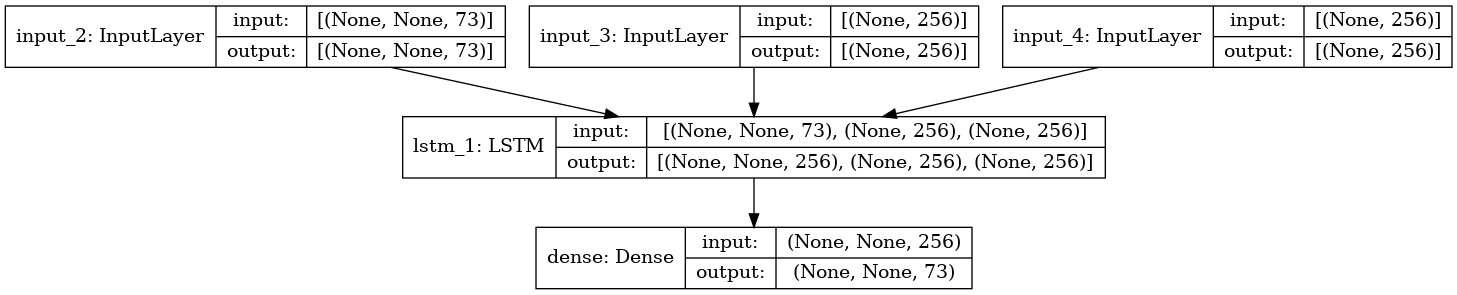

In [54]:
utils.plot_model(decoder_model, show_shapes=True)

## 왜 인풋이 세 개나 되죠?ㅋㅋㅋㅋㅋㅋㅋㅋㅋ

# 4. 단어에서 정수로, 정수에서 단어로 바꾸는 사전(dictionary)을 준비해 둡니다.

In [ ]:
테스트 결과를 해석하기 위해선 다시 사전이 필요하겠죠? 
우리는 이전 스텝에서 문장을 숫자 인덱스로 바꾸는 Tokenizer를 만들면서 자동으로 만들어진 사전을 이미 가지고 있습니다.

In [ ]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

# 5. 이제 예측 과정을 위한 함수 decode_sequence()를 구현

In [ ]:
이제 예측 과정을 위한 함수 decode_sequence()를 구현합니다. 
decode_sequence()의 입력으로 들어가는 것은 번역하고자 하는 문장의 정수 시퀀스입니다. 
decode_sequence() 내부에는 인코더를 구현한 encoder_model이 있어서 이 모델에 번역하고자 하는 문장의 정수 시퀀스인 'input_seq'를 입력하면,
encoder_model은 마지막 시점의 hidden state를 리턴합니다.

In [ ]:
이 hidden state는 디코더의 첫번째 시점의 hidden state가 되고, 
디코더는 이제 번역 문장을 완성하기 위한 예측 과정을 진행합니다. 
디코더의 예측 과정에서는 이전 시점에서 예측한 단어를 디코더의 현재 시점의 입력으로 넣어주는 작업을 진행합니다. 
그리고 이 작업은 종료를 의미하는 종료 토큰을 만나거나, 주어진 최대 길이를 넘을 때까지 반복합니다.

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

# 6. 이렇게 구현한 함수에 번역하고자 하는 문장의 인덱스를 임의로 입력하여 출력 결과를 테스트해보겠습니다.

In [ ]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

# 7-10. 단어수준으로 번역기 업그레이드하기

# 라이브러리 확인

In [ ]:
import tensorflow

print(tensorflow.__version__)

In [ ]:
실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다. 하지만 실제 번역기의 경우에는 글자 단위가 아니라 단어 단위(Word-level)에서 구현되는 것이 좀 더 보편적입니다.

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical() 함수가 아닌 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

# Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [ ]:
글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

1. 구두점(Punctuation)을 단어와 분리해주세요.
일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization) 라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요, 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.
예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면 ['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로 좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.
!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다. 이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

분리 전 : he is a Good boy!
분리 후 : he is a Good boy !
2. 소문자로 바꿔주세요.
기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

변환 전 : he is a Good boy !
변환 후 : he is a good boy !
3. 띄어쓰기 단위로 토큰화를 수행하세요.
띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

토큰화 전 : 'he is a good boy !'
토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']

# Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

In [ ]:
글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 <sos>가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 <eos>가 필요합니다.
예를 들어 번역 문장이 "Courez!" 였다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

Step 1을 수행한 후 : ['courez', '!']
이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

입력 시퀀스 : ['<sos>', 'courez', '!']
레이블 시퀀스 : ['courez', '!', '<eos>']
참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!
Step 1을 수행하는 중간에 수행해도 상관없습니다.

# Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [ ]:
딥러닝 모델은 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요.
케라스 토크나이저의 사용법은 아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리에 설명되어 있습니다.

위키독스
위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고, tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

# Step 4. 임베딩 층(Embedding layer) 사용하기

In [ ]:
이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.
임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의 1. 케라스 임베딩 층(Keras Embedding layer) 을 참고하세요.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Masking

# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)
encoder_lstm = LSTM(hidden state의 크기, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

In [ ]:
주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만, 디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 한다는 것입니다!

# Step 5. 모델 구현하기


In [ ]:
글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요! 이때는 label이 integer 값이므로 categorical entropy loss가 아닌 sparse categorical entropy loss를 사용합니다.

# Step 6. 모델 평가하기

In [ ]:
단어 단위 번역기를 이용하여 훈련 데이터의 샘플과 테스트 데이터의 샘플로 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요. 이전 스텝들에서 우리가 공부했던 모델의 경우 글자 단위에서 구현된 번역기이며 현재 프로젝트를 진행할 때 사용하는 모델은 단어 단위에서 구현되는 번역기입니다.

Embedding layer가 추가되기 때문에 학습했던 내용 그대로 사용할 경우 shape에서 error가 발생합니다.
decode sentence를 구성할 때 고민해보세요!!




tf.keras.layers.LSTM
https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

LSTM return_state, return_sequence
https://wikidocs.net/106473

https://simpling.tistory.com/19